# In this notebook, I'll attempt to sparsify some reward models, both regression-based and DRLHP.

In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product, islice
import h5py
import random

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import imageio
from IPython.display import Image
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eric/Co

## I'll first load up a regression-trained reward model

In [2]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [3]:
env_id = "PongNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [4]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [5]:
class RewardData(th.utils.data.Dataset):
    def __init__(self, train=True):
        self.f = h5py.File(f"../datasets/rewards_{env_id}.hdf5", 'r')
        if train:
            self.group = self.f['train']
        else:
            self.group = self.f['test']
    
    def __getitem__(self, k):
        if k % 2 == 0:
            input = self.group['zeros-inputs'][k // 2]
            label = self.group['zeros-labels'][k // 2]
            return (input, label)
        else:
            input = self.group['ones-inputs'][k // 2]
            label = self.group['ones-labels'][k // 2]
            return (input, label)
    
    def __len__(self):
        return self.group['ones-labels'].shape[0] + self.group['zeros-labels'].shape[0]
    
    def close(self):
        self.f.close()
        
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('CnnPolicy', env).policy
        self.reward_net = nn.Linear(512, 1).to(device)
        self.device = device
    
    def forward(self, obs):
        if type(obs) is np.ndarray:
            obs = th.from_numpy(obs)
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(obs_transposed.to(self.device))
        return self.reward_net(latent)
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [49]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))


loss_fn = th.nn.MSELoss()
def reward_model_saliency(model: RewardModel, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model(obs_copy)
    return loss_fn(baseline, modified).item()


In [7]:
train = RewardData(train=True)
test = RewardData(train=False)

train_loader = th.utils.data.DataLoader(train, batch_size=20, shuffle=True, num_workers=0)
test_loader = th.utils.data.DataLoader(test, batch_size=20, shuffle=False, num_workers=0)

In [8]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/pong_rm_v1.pt"))

<All keys matched successfully>

## I'll do a sanity check on the dataset and on the reward model:

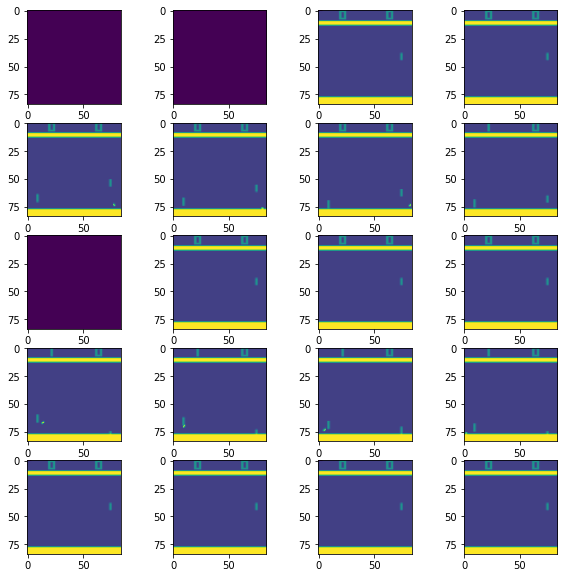

In [9]:
plt.figure(figsize=(10, 10))
for n in range(5):
    for k in range(4):
        plt.subplot(5, 4, n*4 + k + 1)
        plt.imshow(train[n][0][:, :, k])

In [10]:
radius = 5
stride = 4

images = []

obs = env.reset()
for _ in tqdm(range(30)):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)

    screenshot = env.render(mode='rgb_array')
    screenshot = screenshot / screenshot.max()
    pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
    max_value = pairs[0][1]
    for loc, value in pairs:
        r, g, b, a = matplotlib.cm.hot(value / max_value)
        region = create_circular_mask(84, 84, center=loc, radius=radius)
        region = skimage.transform.resize(region, (210, 160))
        spot = np.zeros((210, 160, 3))
        spot[:, :, 0] = r * region
        spot[:, :, 1] = g * region
        spot[:, :, 2] = b * region
        spot = spot * a
        screenshot = spot + (1-spot)*screenshot
        screenshot = screenshot / screenshot.max()
    images.append(screenshot)
    
images = [(img*255).astype(np.uint8) for img in images]

imageio.mimsave('tmp/pong-regression-saliency.gif', images, fps=5)

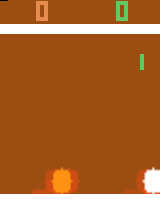

In [11]:
Image(filename="tmp/pong-regression-saliency.gif")

## This reward model is clearly pretty messy, but it seems to vaguely follow the puck position. Let's see do some sparsification now.

## Define helper functions for shaping reward

In [12]:
def first_three(obs):
    obs_copy = np.copy(obs)
    obs_copy[:, :, :, 0] = 0
    obs_copy[:, :, :, 1:4] = obs[:, :, :, 0:3]
    return obs_copy

def last_three(obs):
    obs_copy = np.copy(obs)
    obs_copy[:, :, :, 0] = 0
    return obs_copy

In [13]:
def shaped_reward(reward_model, phi, obs, gamma=0.99):
    if type(obs) is np.ndarray:
        reward = reward_model(obs)
        if type(reward) is np.ndarray:
            reward = th.tensor(reward).to(device)
        return reward + gamma*phi(last_three(obs)) - phi(first_three(obs))
    else:
        return th.tensor(reward_model(obs.detach().numpy())).to(device) + gamma*phi(last_three(obs)) - phi(first_three(obs))


In [14]:
def sum_pow(x, p=1/2):
    return th.sum(th.pow(th.abs(x), p))

def mean_pow(x, p=1/2):
    return th.mean(th.pow(th.abs(x), p))

def E_norm(x, p=1/2):
    return th.pow(mean_pow(x, p), 1/p)

## Some sanity checks for the helper functions:

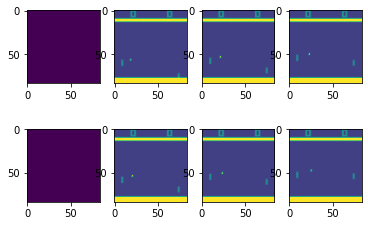

In [15]:
for k in range(4):
    plt.subplot(2, 4, k+1)
    plt.imshow(first_three(obs)[0, :, :, k])

for k in range(4):
    plt.subplot(2, 4, 4 + k+1)
    plt.imshow(last_three(obs)[0, :, :, k])

In [16]:
E_norm(th.ones(4,))

tensor(1.)

In [17]:
E_norm(2*th.ones(4,))

tensor(2.0000)

In [18]:
E_norm(th.tensor([1., 2.]), p=1)

tensor(1.5000)

In [19]:
phi = lambda obs: 0
with th.no_grad():
    print(rm(obs))
    print(shaped_reward(rm, phi, obs))

tensor([[0.0154]], device='cuda:0')
tensor([[0.0154]], device='cuda:0')


In [20]:
phi = lambda obs: 1
with th.no_grad():
    print(rm(obs))
    print(shaped_reward(rm, phi, obs))

tensor([[0.0154]], device='cuda:0')
tensor([[0.0054]], device='cuda:0')


## Okay so things seem to be working. I'll first measure sparsity (p=1/2):

In [21]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(rm, lambda x: 0, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2).item())

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



0.29819509387016296


## And I'll now sparsify the reward model:

In [22]:
phi_baseline = RewardModel(env, device)
optimizer = th.optim.Adam(phi_baseline.parameters(), lr=1e-5)

In [23]:
num_batches = 0
for _ in range(1):
    for samples, targets in tqdm(train_loader):
        optimizer.zero_grad()
        loss = E_norm(shaped_reward(rm, phi_baseline, samples))
        loss.backward()
        optimizer.step()
        num_batches += 1

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [39]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(rm, phi_baseline, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2).item())

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



0.08185474574565887


## Alright so this is definitely sparser. Let's visualize:

In [24]:
radius = 5
stride = 4

images = []

reward_model = lambda obs: shaped_reward(rm, phi_baseline, obs)

obs = env.reset()
for _ in tqdm(range(30)):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)

    screenshot = env.render(mode='rgb_array')
    screenshot = screenshot / screenshot.max()
    pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(reward_model, obs, e, radius=radius))
    max_value = pairs[0][1]
    for loc, value in pairs:
        r, g, b, a = matplotlib.cm.hot(value / max_value)
        region = create_circular_mask(84, 84, center=loc, radius=radius)
        region = skimage.transform.resize(region, (210, 160))
        spot = np.zeros((210, 160, 3))
        spot[:, :, 0] = r * region
        spot[:, :, 1] = g * region
        spot[:, :, 2] = b * region
        spot = spot * a
        screenshot = spot + (1-spot)*screenshot
        screenshot = screenshot / screenshot.max()
    images.append(screenshot)
    
images = [(img*255).astype(np.uint8) for img in images]

imageio.mimsave('tmp/pong-regression-saliency-sparse.gif', images, fps=5)


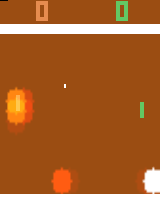

In [25]:
Image(filename="tmp/pong-regression-saliency-sparse.gif")

## Hmmm this doesn't seem to be any more interpretable. Let's try training for longer:

In [26]:
num_batches = 0
for _ in tqdm(range(3)):
    for samples, targets in train_loader:
        optimizer.zero_grad()
        loss = E_norm(shaped_reward(rm, phi_baseline, samples))
        loss.backward()
        optimizer.step()
        num_batches += 1

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [27]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(rm, phi_baseline, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2).item())

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



0.027283821254968643


In [28]:
radius = 5
stride = 4

images = []

reward_model = lambda obs: shaped_reward(rm, phi_baseline, obs)

obs = env.reset()
for _ in tqdm(range(30)):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)

    screenshot = env.render(mode='rgb_array')
    screenshot = screenshot / screenshot.max()
    pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(reward_model, obs, e, radius=radius))
    max_value = pairs[0][1]
    for loc, value in pairs:
        r, g, b, a = matplotlib.cm.hot(value / max_value)
        region = create_circular_mask(84, 84, center=loc, radius=radius)
        region = skimage.transform.resize(region, (210, 160))
        spot = np.zeros((210, 160, 3))
        spot[:, :, 0] = r * region
        spot[:, :, 1] = g * region
        spot[:, :, 2] = b * region
        spot = spot * a
        screenshot = spot + (1-spot)*screenshot
        screenshot = screenshot / screenshot.max()
    images.append(screenshot)
    
images = [(img*255).astype(np.uint8) for img in images]

imageio.mimsave('tmp/pong-regression-saliency-sparse-moretrained.gif', images, fps=5)


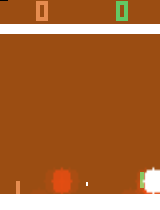

In [29]:
Image(filename="tmp/pong-regression-saliency-sparse-moretrained.gif")

## Let's train for even longer now!

In [30]:
num_batches = 0
for _ in tqdm(range(10)):
    for samples, targets in train_loader:
        optimizer.zero_grad()
        loss = E_norm(shaped_reward(rm, phi_baseline, samples))
        loss.backward()
        optimizer.step()
        num_batches += 1

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [31]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(rm, phi_baseline, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2).item())

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



nan


# Okay so training the shaping function for too long breaks it. Let's try now adding a random network to the reward and then resparsifying.

In [36]:
noise_net = RewardModel(env, device)

In [37]:
alpha = 0.5
reward_model = lambda obs: rm(obs) + alpha*noise_net(obs)

In [38]:
reward_model(obs)

tensor([[0.3561]], device='cuda:0', grad_fn=<AddBackward0>)

In [44]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(reward_model, lambda obs: 0, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2).item())

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



0.6231981515884399


In [50]:
radius = 5
stride = 4

images = []

obs = env.reset()
for _ in tqdm(range(30)):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)

    screenshot = env.render(mode='rgb_array')
    screenshot = screenshot / screenshot.max()
    pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
    max_value = pairs[0][1]
    for loc, value in pairs:
        r, g, b, a = matplotlib.cm.hot(value / max_value)
        region = create_circular_mask(84, 84, center=loc, radius=radius)
        region = skimage.transform.resize(region, (210, 160))
        spot = np.zeros((210, 160, 3))
        spot[:, :, 0] = r * region
        spot[:, :, 1] = g * region
        spot[:, :, 2] = b * region
        spot = spot * a
        screenshot = spot + (1-spot)*screenshot
        screenshot = screenshot / screenshot.max()
    images.append(screenshot)
    
images = [(img*255).astype(np.uint8) for img in images]

imageio.mimsave('tmp/pong-regression-noise-saliency.gif', images, fps=5)


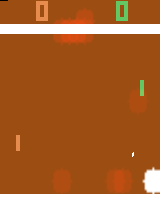

In [51]:
Image(filename="tmp/pong-regression-noise-saliency.gif")

## Actually, let's do this experiment with breakout instead

In [52]:
env_id = "BreakoutNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 3
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [53]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [54]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/breakout_rm_v1.pt"))

<All keys matched successfully>

In [57]:
radius = 5
stride = 4

images = []

obs = env.reset()
for _ in tqdm(range(30)):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)

    screenshot = env.render(mode='rgb_array')
    screenshot = screenshot / screenshot.max()
    pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
    max_value = pairs[0][1]
    for loc, value in pairs:
        r, g, b, a = matplotlib.cm.hot(value / max_value)
        region = create_circular_mask(84, 84, center=loc, radius=radius)
        region = skimage.transform.resize(region, (210, 160))
        spot = np.zeros((210, 160, 3))
        spot[:, :, 0] = r * region
        spot[:, :, 1] = g * region
        spot[:, :, 2] = b * region
        spot = spot * a
        screenshot = spot + (1-spot)*screenshot
        screenshot = screenshot / screenshot.max()
    images.append(screenshot)
    
images = [(img*255).astype(np.uint8) for img in images]

imageio.mimsave('tmp/breakout-regression-baseline-saliency.gif', images, fps=5)


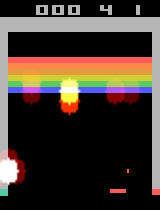

In [58]:
Image(filename="tmp/breakout-regression-baseline-saliency.gif")

## baseline sparsity:

In [59]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(rm, lambda x: 0, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2).item())

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



0.0021367629524320364


## sparsify the baseline:

In [60]:
phi_baseline = RewardModel(env, device)
optimizer = th.optim.Adam(phi_baseline.parameters(), lr=1e-5)

In [61]:
num_batches = 0
for _ in range(1):
    for samples, targets in tqdm(train_loader):
        optimizer.zero_grad()
        loss = E_norm(shaped_reward(rm, phi_baseline, samples))
        loss.backward()
        optimizer.step()
        num_batches += 1

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [62]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(rm, phi_baseline, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2).item())

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



nan


In [32]:
import logging

sys.path.insert(1, "/home/eric/Code/chai/test/learning-from-human-preferences")
sys.path.insert(2, "/home/eric/Code/chai/test/learning-from-human-preferences/drlhp")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import easy_tf_log
#     from drlhp import reward_predictor
    from drlhp.reward_predictor_core_network import net_cnn
    from drlhp.HumanPreferencesEnvWrapper import _make_reward_predictor

In [33]:
ckpt_dir = Path('/home/eric/Code/chai/test/learning-from-human-preferences/runs/pong_45cb953/reward_predictor_checkpoints')
log_dir = Path('logs')
logger = logging.getLogger("testytest")

obs_shape = (84, 84, 4)

In [34]:
rp = _make_reward_predictor(reward_predictor_network=net_cnn,
                           log_dir=log_dir,
                           obs_shape=obs_shape,
                           logger=logger,
                           checkpoint_dir=ckpt_dir)

RewardPredictorEnsemble created


FileNotFoundError: No reward predictor checkpoint found in '/home/eric/Code/chai/test/learning-from-human-preferences/runs/pong_45cb953/reward_predictor_checkpoints'

In [35]:
def reward_model_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model.reward(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model.reward(obs_copy)
    return (np.abs(baseline - modified) ** 2).item()


In [10]:
def first_three(obs):
    obs_copy = np.copy(obs)
    obs_copy[:, :, :, 0] = 0
    obs_copy[:, :, :, 1:4] = obs[:, :, :, 0:3]
    return obs_copy

def last_three(obs):
    obs_copy = np.copy(obs)
    obs_copy[:, :, :, 0] = 0
    return obs_copy

In [11]:
type(obs) is np.ndarray

True

In [61]:
def shaped_reward(reward_model, phi, obs, gamma=0.99):
    if type(obs) is np.ndarray:
        return 100*th.tensor(reward_model.reward(obs)).to(device) + gamma*phi(last_three(obs)) - phi(first_three(obs))
    else:
        return 100*th.tensor(reward_model.reward(obs.detach().numpy())).to(device) + gamma*phi(last_three(obs)) - phi(first_three(obs))


In [62]:
def sum_pow(x, p=1/2):
    return th.sum(th.pow(th.abs(x), p))

def mean_pow(x, p=1/2):
    return th.mean(th.pow(th.abs(x), p))

def E_norm(x, p=1/2):
    return th.pow(mean_pow(x, p), 1/p)

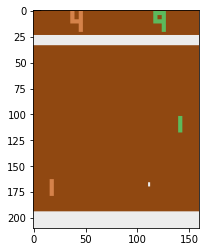

In [63]:
obs = env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)

plt.imshow(env.get_images()[0])

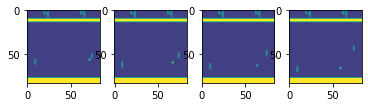

In [64]:
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k])

### sanity check on drlhp-saliency

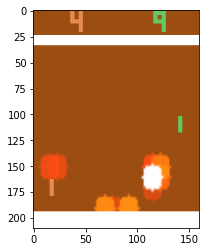

In [66]:
radius = 5
stride = 4

phi = lambda x: 0
reward_model = lambda obs: shaped_reward(rp, phi, obs)

screenshot_saved = env.get_images()[0]
# Baseline (1)
screenshot = np.copy(screenshot_saved)
screenshot = screenshot / screenshot.max()
pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rp, obs, e, radius=radius))
max_value = pairs[0][1]
for loc, value in pairs:
    r, g, b, a = matplotlib.cm.hot(value / max_value)
    region = create_circular_mask(84, 84, center=loc, radius=radius)
    region = skimage.transform.resize(region, (210, 160))
    spot = np.zeros((210, 160, 3))
    spot[:, :, 0] = r * region
    spot[:, :, 1] = g * region
    spot[:, :, 2] = b * region
    spot = spot * a
    screenshot = spot + (1-spot)*screenshot
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

In [67]:
train = RewardData(train=True)
test = RewardData(train=False)

train_loader = th.utils.data.DataLoader(train, batch_size=20, shuffle=True, num_workers=0)
test_loader = th.utils.data.DataLoader(test, batch_size=20, shuffle=False, num_workers=0)

### define potential function

In [68]:
phi = RewardModel(env, device)
optimizer = th.optim.Adam(phi.parameters(), lr=1e-5)

### sanity check on shaping

In [69]:
with th.no_grad():
    print(shaped_reward(rp, lambda x: 0, obs))
    print(shaped_reward(rp, phi, obs))

tensor([3.1373], device='cuda:0')
tensor([[3.1293]], device='cuda:0')


### compute baseline sparsity

In [70]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(rp, lambda x: 0, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2).item())


2.6714415550231934


### compute sparsity with randomly-initialized shaping function

In [71]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(rp, phi, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2).item())


1068.4407958984375


In [72]:
num_batches = 0
for _ in range(1):
    for samples, targets in tqdm(islice(train_loader, 500)):
        optimizer.zero_grad()
        loss = E_norm(shaped_reward(rp, phi, samples))
        loss.backward()
        optimizer.step()
        num_batches += 1

In [73]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(rp, phi, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2).item())


1067.19873046875


In [74]:
num_batches = 0
for _ in range(1):
    for samples, targets in tqdm(islice(train_loader, 4000)):
        optimizer.zero_grad()
        loss = E_norm(shaped_reward(rp, phi, samples))
        loss.backward()
        optimizer.step()
        num_batches += 1

In [75]:
spow = 0
outof = 0
for samples, targets in tqdm(islice(test_loader, 500)):
    with th.no_grad():
        spow += sum_pow(shaped_reward(rp, phi, samples), p=1/2)
        outof += len(samples)
print(th.pow(spow/outof, 2).item())


nan
